## B. BUREAU RECORD TRAINING

This notebook attempts to exploit the correlation between past bureau record and current defaulting rate. We have each training sample being one bureau record, and target being the corresponding current target --- bureau records belonging to the same customer will all use this customer's current target. We then use LightGBM classifier with auc loss to predict the probability of each bureau record belonging to a customer who has defaulted loan currently. When the model is trained, the prediction (a probability within (0,1)) is grouped by the current customer ID, and statistics such as mean/sum are computed. These statistics are saved to disk to be merged to the main training table.

In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler

from lightgbm import LGBMClassifier, LGBMRegressor
import gc

import matplotlib.pyplot as plt
import seaborn as sns

import os
print(os.listdir('C:/Users/monis/Desktop/Home credit risk'))
    
gc.enable()

['.ipynb_checkpoints', 'Automated Hyper parameter tuning.ipynb', 'baseline_lgb.csv', 'baseline_lgb_domain_features.csv', 'bayes_test.csv', 'H20AutoML.ipynb', 'HomeCreditRiskKaggle.ipynb', 'Kaggle competition.docx', 'LightGBM with Simple Features.ipynb', 'log_reg_baseline.csv', 'random_forest_baseline.csv', 'random_forest_baseline_domain.csv', 'sample_submission.csv']


In [2]:
data = pd.read_csv('application_train.csv', usecols=['SK_ID_CURR','TARGET'])

Create features for each bureau record. Apart from raw features from bureau table, we also compute:
* ratio between credit in debt and total credit
* ratio between credit limit and total credit
* ratio between credit overdue and total credit
* difference between actual and expected account close date

...

In [3]:
buro = pd.read_csv('bureau.csv')

buro['DAYS_CREDIT_ENDDATE'].loc[buro['DAYS_CREDIT_ENDDATE'] < -40000] = np.nan
buro['DAYS_CREDIT_UPDATE'].loc[buro['DAYS_CREDIT_UPDATE'] < -40000] = np.nan
buro['DAYS_ENDDATE_FACT'].loc[buro['DAYS_ENDDATE_FACT'] < -40000] = np.nan

buro['AMT_DEBT_RATIO'] = buro['AMT_CREDIT_SUM_DEBT']/(1+buro['AMT_CREDIT_SUM'])
buro['AMT_LIMIT_RATIO'] = buro['AMT_CREDIT_SUM_LIMIT']/(1+buro['AMT_CREDIT_SUM'])
buro['AMT_SUM_OVERDUE_RATIO'] = buro['AMT_CREDIT_SUM_OVERDUE']/(1+buro['AMT_CREDIT_SUM'])
buro['AMT_MAX_OVERDUE_RATIO'] = buro['AMT_CREDIT_MAX_OVERDUE']/(1+buro['AMT_CREDIT_SUM'])
buro['DAYS_END_DIFF'] = buro['DAYS_ENDDATE_FACT'] - buro['DAYS_CREDIT_ENDDATE']

#Label Encoding
categorical_feats = [
    f for f in buro.columns if buro[f].dtype == 'object'
]

for f_ in categorical_feats:
    nunique = buro[f_].nunique(dropna=False)
    print(f_,nunique,buro[f_].unique())
    buro[f_], indexer = pd.factorize(buro[f_])
    
buro.head()

C:\Users\monis\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


CREDIT_ACTIVE 4 ['Closed' 'Active' 'Sold' 'Bad debt']
CREDIT_CURRENCY 4 ['currency 1' 'currency 2' 'currency 4' 'currency 3']
CREDIT_TYPE 15 ['Consumer credit' 'Credit card' 'Mortgage' 'Car loan' 'Microloan'
 'Loan for working capital replenishment' 'Loan for business development'
 'Real estate loan' 'Unknown type of loan' 'Another type of loan'
 'Cash loan (non-earmarked)' 'Loan for the purchase of equipment'
 'Mobile operator loan' 'Interbank credit'
 'Loan for purchase of shares (margin lending)']


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,...,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,AMT_DEBT_RATIO,AMT_LIMIT_RATIO,AMT_SUM_OVERDUE_RATIO,AMT_MAX_OVERDUE_RATIO,DAYS_END_DIFF
0,215354,5714462,0,0,-497,0,-153.0,-153.0,NaN,0,...,NaN,0.0,0,-131.0,NaN,0.000000,NaN,0.0,NaN,0.0
1,215354,5714463,1,0,-208,0,1075.0,NaN,NaN,0,...,NaN,0.0,1,-20.0,NaN,0.761517,NaN,0.0,NaN,NaN
2,215354,5714464,1,0,-203,0,528.0,NaN,NaN,0,...,NaN,0.0,0,-16.0,NaN,NaN,NaN,0.0,NaN,NaN
3,215354,5714465,1,0,-203,0,NaN,NaN,NaN,0,...,NaN,0.0,1,-16.0,NaN,NaN,NaN,0.0,NaN,NaN
4,215354,5714466,1,0,-629,0,1197.0,NaN,77674.5,0,...,NaN,0.0,0,-21.0,NaN,NaN,NaN,0.0,0.028768,NaN


Aggragate the balance info for each buro record. Features include:
* month account closed relative to current application
* month with days past due (DPD) relative to current application
* mean/sum/max DPD of each bureau account

...

In [4]:
bubl = pd.read_csv('bureau_balance.csv')
#what is the last month with DPD
bubl_last_DPD = bubl[bubl.STATUS.isin(['1','2','3','4','5'])].groupby(['SK_ID_BUREAU'])['MONTHS_BALANCE'].max()
bubl_last_DPD.rename('MONTH_LAST_DPD', inplace=True)
#print(bubl_last_DPD.head())

#what is the last month complete
bubl_last_C = bubl[bubl.STATUS=='C'].groupby(['SK_ID_BUREAU'])['MONTHS_BALANCE'].min()
bubl_last_C.rename('MONTH_LAST_C',inplace=True)
#print(bubl_last_C.head())

bubl['STATUS_DPD'] = bubl['STATUS']
bubl['STATUS_DPD'].loc[bubl['STATUS_DPD'].isin(['C','X'])]=np.nan
bubl['STATUS_DPD'] = bubl['STATUS_DPD'].astype('float')
bubl['YEAR_SCALE'] = (bubl['MONTHS_BALANCE']/12.0).apply(np.exp)
bubl['STATUS_DPD_SCALE'] = bubl['STATUS_DPD'] * bubl['YEAR_SCALE']
num_aggregations = {
    'STATUS_DPD': [ 'max', 'mean', 'sum'],
    'STATUS_DPD_SCALE': [ 'sum',],
    'YEAR_SCALE': [ 'sum']
}
balance = bubl.groupby('SK_ID_BUREAU').agg(num_aggregations)
balance.columns = pd.Index(['balance_' + e[0] + "_" + e[1].upper() for e in balance.columns.tolist()])
balance['balance_STATUS_DPD_SCALE_MEAN'] = balance['balance_STATUS_DPD_SCALE_SUM']/balance['balance_YEAR_SCALE_SUM']
del balance['balance_YEAR_SCALE_SUM']
gc.collect()
bubl_STATUS = pd.concat([bubl[['SK_ID_BUREAU','MONTHS_BALANCE']], pd.get_dummies(bubl['STATUS'], prefix='STATUS')], axis=1)
bubl_STATUS['STATUS_DPD'] = bubl_STATUS['STATUS_1'] + bubl_STATUS['STATUS_2'] + bubl_STATUS['STATUS_3'] + bubl_STATUS['STATUS_4'] + bubl_STATUS['STATUS_5'] 
num_aggregations = {
    'STATUS_C': [ 'sum'],
    'STATUS_X': [ 'sum'],
    'STATUS_0': [ 'sum'],
    'STATUS_DPD': ['sum']
}
balance_tot =  bubl_STATUS.groupby('SK_ID_BUREAU').agg(num_aggregations)
balance_12 =  bubl_STATUS.loc[bubl_STATUS['MONTHS_BALANCE']>=-12].groupby('SK_ID_BUREAU').agg(num_aggregations)
balance_tot.columns = pd.Index(['balance_tot_' + e[0] + "_" + e[1].upper() for e in balance_tot.columns.tolist()])
balance_12.columns = pd.Index(['balance_12_' + e[0] + "_" + e[1].upper() for e in balance_12.columns.tolist()])
balance_tot['balance_tot_STATUS_DPD_RATIO'] = balance_tot['balance_tot_STATUS_DPD_SUM']/(0.001 + balance_tot['balance_tot_STATUS_0_SUM'] + balance_tot['balance_tot_STATUS_DPD_SUM'])
balance_12['balance_12_STATUS_DPD_RATIO'] = balance_12['balance_12_STATUS_DPD_SUM']/(0.001 + balance_12['balance_12_STATUS_0_SUM'] + balance_12['balance_12_STATUS_DPD_SUM'])
balance = balance.merge(balance_tot, how='outer', on='SK_ID_BUREAU')             
balance = balance.merge(balance_12, how='outer', on='SK_ID_BUREAU')
balance['balance_has_DPD'] = (balance['balance_STATUS_DPD_MAX']>0).astype('int')

del balance_tot, balance_12, bubl_STATUS
gc.collect()
balance.head()

,balance_STATUS_DPD_MAX,balance_STATUS_DPD_MEAN,balance_STATUS_DPD_SUM,balance_STATUS_DPD_SCALE_SUM,balance_STATUS_DPD_SCALE_MEAN,balance_tot_STATUS_C_SUM,balance_tot_STATUS_X_SUM,balance_tot_STATUS_0_SUM,balance_tot_STATUS_DPD_SUM,balance_tot_STATUS_DPD_RATIO,balance_12_STATUS_C_SUM,balance_12_STATUS_X_SUM,balance_12_STATUS_0_SUM,balance_12_STATUS_DPD_SUM,balance_12_STATUS_DPD_RATIO,balance_has_DPD
SK_ID_BUREAU,,,,,,,,,,,,,,,,
5001709,NaN,NaN,0.0,0.0,0.0,86,11,0,0,0.0,13.0,0.0,0.0,0.0,0.0,0
5001710,0.0,0.0,0.0,0.0,0.0,48,30,5,0,0.0,13.0,0.0,0.0,0.0,0.0,0
5001711,0.0,0.0,0.0,0.0,0.0,0,1,3,0,0.0,0.0,1.0,3.0,0.0,0.0,0
5001712,0.0,0.0,0.0,0.0,0.0,9,0,10,0,0.0,9.0,0.0,4.0,0.0,0.0,0
5001713,NaN,NaN,0.0,0.0,0.0,0,22,0,0,0.0,0.0,13.0,0.0,0.0,0.0,0


Merge bureau balance feature with main bureau table:

In [5]:
buro_meta = buro.merge(balance, on='SK_ID_BUREAU', how='left')
del buro, balance
gc.collect()
print("bureau data shape", buro_meta.shape)

bureau data shape (1716428, 38)


Broadcast current target to bureau record, according to the current ID each bureau record correspond to.

In [6]:
target_map = pd.Series(data.TARGET.values, index=data.SK_ID_CURR.values)
y = buro_meta['SK_ID_CURR'].map(target_map)

Split train and test set (test set are those without target)

In [7]:
train_x = buro_meta.loc[~y.isnull()]
test_x = buro_meta.loc[y.isnull()]
train_y = y.loc[~y.isnull()]

In [8]:
excluded_feats = ['SK_ID_CURR','SK_ID_BUREAU']
features = [f_ for f_ in train_x.columns.values if not f_ in excluded_feats]
print(excluded_feats)

train_x = buro_meta.loc[~y.isnull()]
test_x = buro_meta.loc[y.isnull()]
train_y = y.loc[~y.isnull()]

# Run a 5 fold
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=777)
oof_preds = np.zeros(train_x.shape[0])
sub_preds = np.zeros(test_x.shape[0])
feature_importance_df = pd.DataFrame()

['SK_ID_CURR', 'SK_ID_BUREAU']


Train LightGBM classifier

In [9]:
scores = []

for n_fold, (trn_idx, val_idx) in enumerate(folds.split(train_x, train_y)):
    trn_x, val_x = train_x[features].iloc[trn_idx], train_x[features].iloc[val_idx]
    trn_y, val_y = train_y.iloc[trn_idx], train_y.iloc[val_idx]
    
    clf = LGBMClassifier(
        n_estimators=5000,
        learning_rate=0.05,
        metric = 'auc',
        num_leaves=20,
        colsample_bytree=0.8,
        subsample=0.9,
        max_depth=5,
        reg_alpha=5,
        reg_lambda=4,
        min_split_gain=0.002,
        min_child_weight=40,
        silent=True,
        verbose=-1,
        n_jobs = 16,
        random_state = n_fold * 619,
        scale_pos_weight = 2
    )
    
    clf.fit(trn_x, trn_y, 
            eval_set= [(val_x, val_y)], 
            eval_metric='auc', verbose=100, early_stopping_rounds=60,
            categorical_feature = categorical_feats,
           )
    
    oof_preds[val_idx] = clf.predict_proba(val_x)[:, 1]
    sub_preds += clf.predict_proba(test_x[features])[:, 1] / folds.n_splits
    
    fold_score = roc_auc_score(val_y, oof_preds[val_idx])
    scores.append(fold_score)
    print('Fold %2d AUC : %.6f' % (n_fold + 1, fold_score))
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importances_
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    del clf, trn_x, trn_y, val_x, val_y
    gc.collect()
    
print('Full AUC score %.6f +- %0.4f' % (roc_auc_score(train_y, oof_preds), np.std(scores)))

C:\Users\monis\Anaconda3\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['CREDIT_ACTIVE', 'CREDIT_CURRENCY', 'CREDIT_TYPE']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
C:\Users\monis\Anaconda3\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['CREDIT_ACTIVE', 'CREDIT_CURRENCY', 'CREDIT_TYPE']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 60 rounds.
[100]	valid_0's auc: 0.612689
[200]	valid_0's auc: 0.616326
[300]	valid_0's auc: 0.618119
[400]	valid_0's auc: 0.619222
[500]	valid_0's auc: 0.619848
[600]	valid_0's auc: 0.620398
[700]	valid_0's auc: 0.62081
[800]	valid_0's auc: 0.621138
[900]	valid_0's auc: 0.621482
[1000]	valid_0's auc: 0.621704
[1100]	valid_0's auc: 0.622079
[1200]	valid_0's auc: 0.622226
Early stopping, best iteration is:
[1222]	valid_0's auc: 0.622263
Fold  1 AUC : 0.622263


C:\Users\monis\Anaconda3\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['CREDIT_ACTIVE', 'CREDIT_CURRENCY', 'CREDIT_TYPE']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
C:\Users\monis\Anaconda3\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['CREDIT_ACTIVE', 'CREDIT_CURRENCY', 'CREDIT_TYPE']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 60 rounds.
[100]	valid_0's auc: 0.608626
[200]	valid_0's auc: 0.611405
[300]	valid_0's auc: 0.613098
[400]	valid_0's auc: 0.614506
[500]	valid_0's auc: 0.615284
[600]	valid_0's auc: 0.615794
[700]	valid_0's auc: 0.616296
[800]	valid_0's auc: 0.616477
[900]	valid_0's auc: 0.616608
Early stopping, best iteration is:
[920]	valid_0's auc: 0.616638
Fold  2 AUC : 0.616638


C:\Users\monis\Anaconda3\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['CREDIT_ACTIVE', 'CREDIT_CURRENCY', 'CREDIT_TYPE']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
C:\Users\monis\Anaconda3\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['CREDIT_ACTIVE', 'CREDIT_CURRENCY', 'CREDIT_TYPE']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 60 rounds.
[100]	valid_0's auc: 0.610357
[200]	valid_0's auc: 0.61379
[300]	valid_0's auc: 0.615626
[400]	valid_0's auc: 0.616642
[500]	valid_0's auc: 0.617559
[600]	valid_0's auc: 0.618181
[700]	valid_0's auc: 0.61862
[800]	valid_0's auc: 0.618939
[900]	valid_0's auc: 0.619167
[1000]	valid_0's auc: 0.619447
[1100]	valid_0's auc: 0.619652
[1200]	valid_0's auc: 0.619818
[1300]	valid_0's auc: 0.619969
[1400]	valid_0's auc: 0.620007
Early stopping, best iteration is:
[1346]	valid_0's auc: 0.620088
Fold  3 AUC : 0.620088


C:\Users\monis\Anaconda3\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['CREDIT_ACTIVE', 'CREDIT_CURRENCY', 'CREDIT_TYPE']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
C:\Users\monis\Anaconda3\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['CREDIT_ACTIVE', 'CREDIT_CURRENCY', 'CREDIT_TYPE']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 60 rounds.
[100]	valid_0's auc: 0.610735
[200]	valid_0's auc: 0.614317
[300]	valid_0's auc: 0.615621
[400]	valid_0's auc: 0.61636
[500]	valid_0's auc: 0.617155
[600]	valid_0's auc: 0.6176
[700]	valid_0's auc: 0.618003
[800]	valid_0's auc: 0.61835
[900]	valid_0's auc: 0.618584
Early stopping, best iteration is:
[913]	valid_0's auc: 0.618619
Fold  4 AUC : 0.618619


C:\Users\monis\Anaconda3\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['CREDIT_ACTIVE', 'CREDIT_CURRENCY', 'CREDIT_TYPE']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
C:\Users\monis\Anaconda3\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['CREDIT_ACTIVE', 'CREDIT_CURRENCY', 'CREDIT_TYPE']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 60 rounds.
[100]	valid_0's auc: 0.612362
[200]	valid_0's auc: 0.615957
[300]	valid_0's auc: 0.617728
[400]	valid_0's auc: 0.618776
[500]	valid_0's auc: 0.619616
[600]	valid_0's auc: 0.620307
[700]	valid_0's auc: 0.620832
[800]	valid_0's auc: 0.621229
[900]	valid_0's auc: 0.621635
[1000]	valid_0's auc: 0.621819
[1100]	valid_0's auc: 0.621935
[1200]	valid_0's auc: 0.62212
[1300]	valid_0's auc: 0.622321
Early stopping, best iteration is:
[1332]	valid_0's auc: 0.622364
Fold  5 AUC : 0.622364
Full AUC score 0.619998 +- 0.0022


Get prediction for each bureau record -- giving each bureau record a score, which meatures how likely it belongs to a user who has defaulting account currently.

In [10]:
train_buro_score = train_x[['SK_ID_CURR','SK_ID_BUREAU','DAYS_CREDIT']]
train_buro_score['score'] = oof_preds
test_buro_score = test_x[['SK_ID_CURR','SK_ID_BUREAU','DAYS_CREDIT']]
test_buro_score['score'] = sub_preds
buro_score = pd.concat([train_buro_score,test_buro_score])
buro_score.to_csv('buro_score.csv',index=False,compression='zip')

C:\Users\monis\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\monis\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


Group by current ID, create aggragated bureau score. These will be the features we use for final training.

Aggragated features include: mean, max, sum, variance, sum of past two year.

Note we subtract the global mean of all predictions, this is to prevent the "sum" feature penalized users with more accounts. The max/mean/var features are not affected by the substraction.

In [11]:
buro_score['score'] -= buro_score['score'].mean()
agg_buro_score = buro_score.groupby('SK_ID_CURR')['score'].agg({'max','mean','sum','var'})

agg_buro_score_recent2y = buro_score.loc[buro_score['DAYS_CREDIT']>-365.25*2].groupby('SK_ID_CURR')['score'].sum()

idx = buro_score.groupby(['SK_ID_CURR'])['DAYS_CREDIT'].idxmax()
agg_buro_score_last = buro_score[['SK_ID_CURR','score']].loc[idx.values]
agg_buro_score_last.set_index('SK_ID_CURR',inplace=True)

agg_buro_score['recent2y_sum'] = agg_buro_score_recent2y
agg_buro_score['last'] = agg_buro_score_last
agg_buro_score = agg_buro_score.add_prefix('buro_score_')
agg_buro_score['TARGET'] = target_map
agg_buro_score.to_csv('agg_buro_score.csv',compression='zip')
agg_buro_score.groupby('TARGET').mean()

,buro_score_mean,buro_score_max,buro_score_var,buro_score_sum,buro_score_recent2y_sum,buro_score_last
TARGET,,,,,,
0.0,-0.001036,0.049015,0.002283,-0.012259,0.078419,0.023395
1.0,0.030455,0.100584,0.004679,0.152567,0.206554,0.064631


Check how the aggregated features are correlated to current target. Idealy we should see a significant correlation.

In [12]:
for col in agg_buro_score.columns:
    print(col,agg_buro_score[col].corr(agg_buro_score['TARGET']))

buro_score_mean 0.19663407724627266
buro_score_max 0.17863053994170114
buro_score_var 0.14087328837824165
buro_score_sum 0.18422802883370876
buro_score_recent2y_sum 0.17187109958035077
buro_score_last 0.1566248889625335
TARGET 1.0


### Plot feature importance

Text(0.5, 1.0, 'Feature scores wrt split importances')

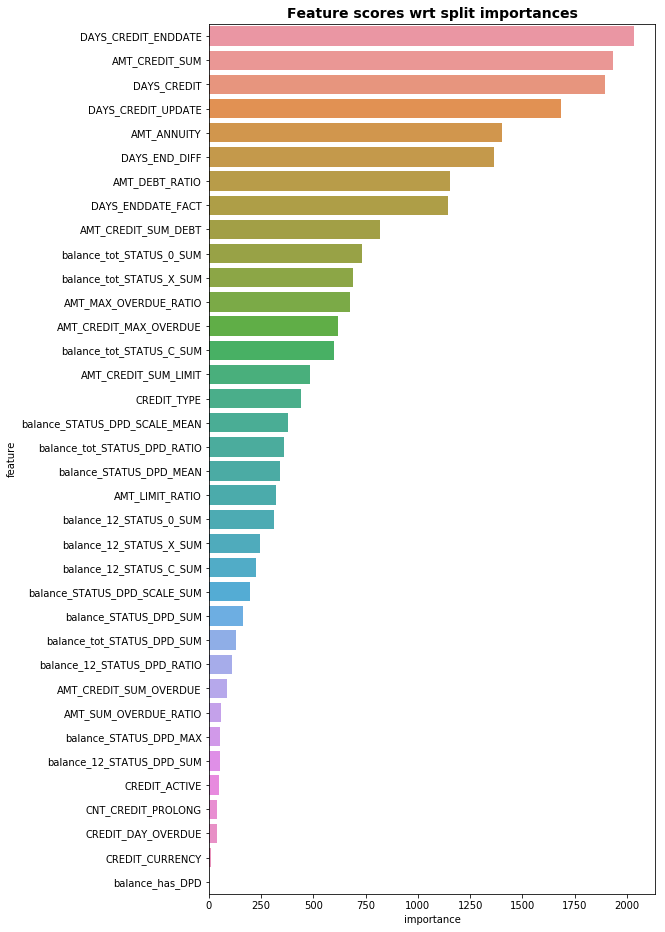

In [13]:
# Plot feature importances
feature_importance = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(
    by="importance", ascending=False)

best_features = feature_importance.iloc[:50].reset_index()

import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(8, 16))
gs = gridspec.GridSpec(1, 1)
# Plot Split importances
ax = plt.subplot(gs[0, 0])
sns.barplot(x='importance', y='feature', data=best_features, ax=ax)
ax.set_title('Feature scores wrt split importances', fontweight='bold', fontsize=14)